In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd

HOUSING_PATH = '../datasets/housing/housing.csv'

def load_housing_data(csv_path=HOUSING_PATH):
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

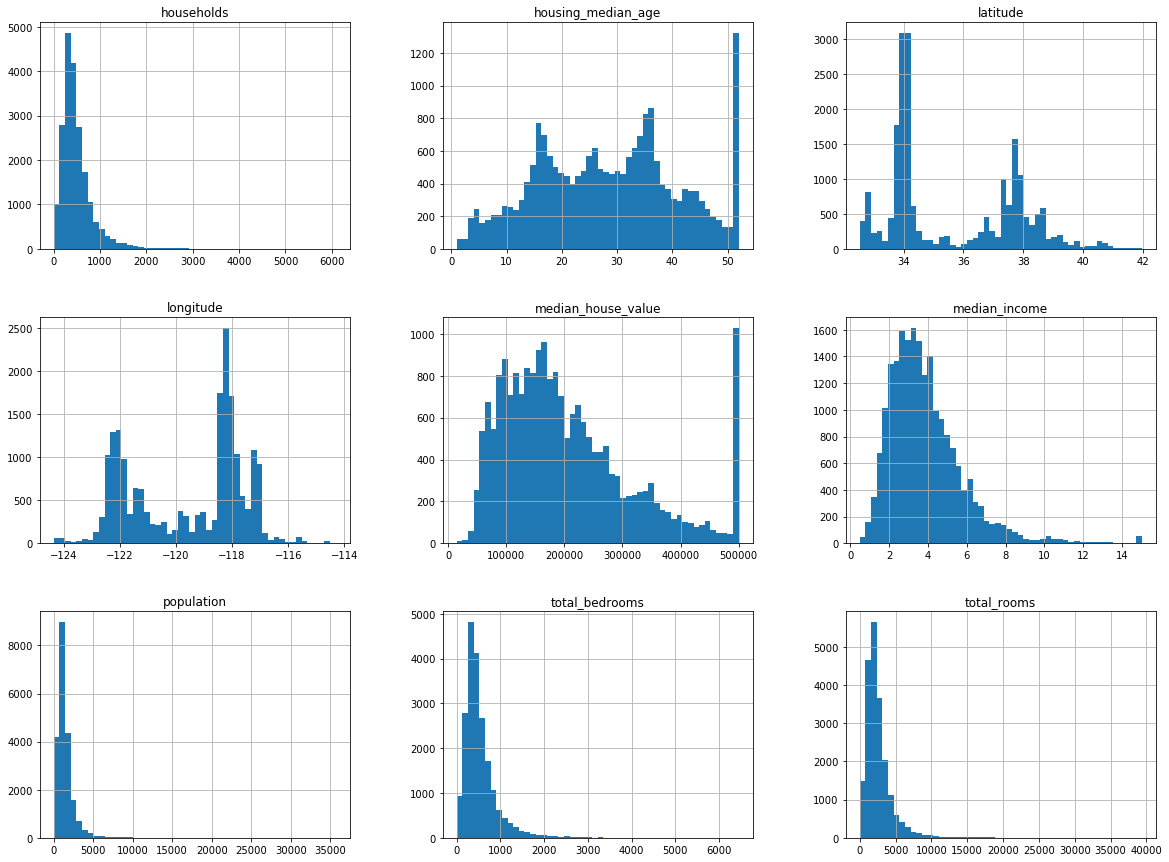

In [7]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
import numpy as np

np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
print('%d train; %d test' % (len(train_set), len(test_set)))

16512 train; 4128 test


In [10]:
import hashlib

def test_set_check(identifier, test_ratio, hf):
    return hf(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data, test_ratio, id_col, hf=hashlib.md5):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hf))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_w_idx = housing.reset_index()
housing_w_idx['id'] = housing['longitude']*1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_w_idx, 0.2, 'id')
print('%d train; %d test' % (len(train_set), len(test_set)))

16267 train; 4373 test


In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print('%d train; %d test' % (len(train_set), len(test_set)))

16512 train; 4128 test


In [13]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
# Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

stratss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratss.split(housing, housing['income_cat']):
    train_set = housing.loc[train_idx]
    test_set = housing.loc[test_idx]

print(train_set['income_cat'].value_counts()/len(train_set))
print(test_set['income_cat'].value_counts()/len(test_set))

for set in train_set, test_set:
    set.drop(['income_cat'], axis=1, inplace=True)

housing = train_set.copy()

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


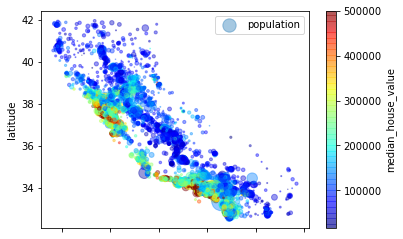

In [15]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
    s=housing['population']/100, label='population',
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

In [73]:
# Estimate standard correlation coefficients.
housing = train_set.copy()
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd82e1eaa90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd82dd40e10>]], dtype=object)

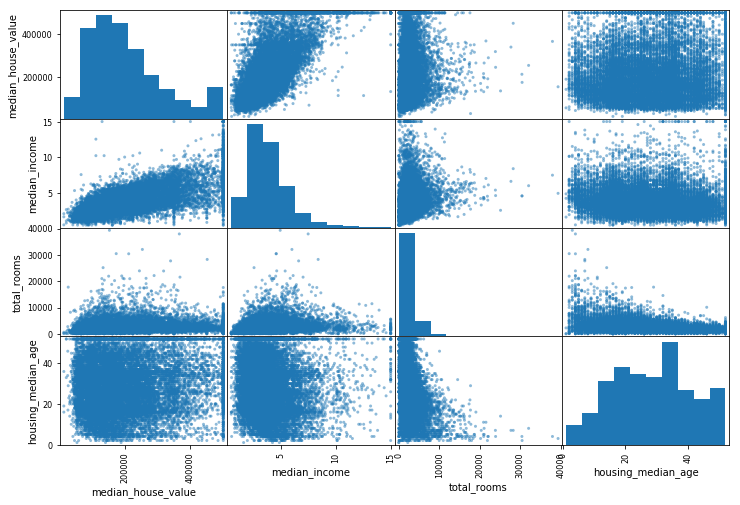

In [17]:
# Scatter matrix
from pandas.plotting import scatter_matrix

scatter_matrix(housing[[
    'median_house_value', 'median_income', 'total_rooms', 'housing_median_age'
]], figsize=(12, 8))

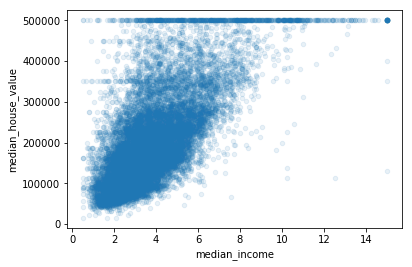

In [18]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
# The horizontal lines are data quirks that should not be learned by our algorithms.

In [19]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedroom_room_ratio'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_room_ratio         -0.259984
Name: median_house_value, dtype: float64

In [20]:
# Get a clean set; separate predictors and labels.
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

# Four options to clean data (handling null values)

# Option 1
# housing.dropna(subset=['total_bedrooms'])

# Option 2
# housing.drop('total_bedrooms', axis=1)

# Option 3
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(median)

# Option 4
from sklearn.preprocessing import Imputer

housing_num = housing.drop('ocean_proximity', axis=1)
imputer = Imputer(strategy='median')
imputer.fit(housing_num) # 'learn' a list of medians
X = imputer.transform(housing_num) # transform it to a list of non-null features
housing_tr = pd.DataFrame(X, columns=housing_num.columns) # convert the list back to a dataframe
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

housing_ocprox = housing['ocean_proximity']
labeler = LabelEncoder()
housing_ocprox_e = labeler.fit_transform(housing_ocprox)

onehoter = OneHotEncoder()
housing_ocprox_1hot = onehoter.fit_transform(housing_ocprox_e.reshape(-1, 1))

# LabelBinarizer = toarray(LabelEncoder + OneHotEncoder)
binarizer = LabelBinarizer(sparse_output=False)
binarizer.fit_transform(housing_ocprox) # == housing_ocprox_1hot.toarray()

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [22]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalization
mmscaler = MinMaxScaler()
mmscaler.fit_transform(housing_tr) # 0 - 1

# Standardization
stdscaler = StandardScaler()
stdscaler.fit_transform(housing_tr) # Zero mean and unit variance

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

In [23]:
# Custom transformers
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attr_names):
        self.attr_names = attr_names

        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        return X[self.attr_names].values


rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [65]:
# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion

num_attrs = list(housing_num)
cat_attrs = ['ocean_proximity']

# All except the last estimator must be transformers.
# The pipeline is used the same way as the last estimator.
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attrs)),
    ('imputer', Imputer(strategy='median')),
    ('attrs_adder', CombinedAttributesAdder()),
    ('minmax_scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attrs)),
    ('binarizer', LabelBinarizer()),
])

# Run transformers in parallel and concatenate their results.
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

In [25]:
# Training a linear regression model and evaluate its RMSE on training data.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(housing_prepared, housing_labels)
predictions = linreg.predict(housing_prepared)
lin_rmse = np.sqrt(mean_squared_error(housing_labels, predictions))
lin_rmse # underfitting the data

68628.198198489219

In [26]:
# Training a decision tree model and evaluate its RMSE on training data.
from sklearn.tree import DecisionTreeRegressor

treereg = DecisionTreeRegressor()
treereg.fit(housing_prepared, housing_labels)
predictions = treereg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, predictions))
tree_rmse # overfitting the data

0.0

In [27]:
# Training a random forest model and evaluate its RMSE on training data.
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, predictions))
forest_rmse

22606.075024605077

In [28]:
from sklearn.model_selection import cross_val_score

def cross_val_rmse(model, instances, labels, k=10):
    scores = cross_val_score(model, instances, labels,
                            scoring='neg_mean_squared_error', cv=k)
    rmse_scores = np.sqrt(-scores)
    print('Scores: %s\nMean: %s\nStandard Deviation: %s\n' %
          (rmse_scores, rmse_scores.mean(), rmse_scores.std()))

In [29]:
# Linear regression vs. decision tree vs. random forest
cross_val_rmse(linreg, housing_prepared, housing_labels)
cross_val_rmse(treereg, housing_prepared, housing_labels)
cross_val_rmse(forest_reg, housing_prepared, housing_labels)

Scores: [ 66782.73843989  66960.47709532  70347.95244419  74739.57052552
  68017.64982197  71193.84183426  64972.66771274  68266.80287987
  71552.91566558  67665.10082067]
Mean: 69049.971724
Standard Deviation: 2732.12093128

Scores: [ 68443.81949122  65930.46980959  71193.1623525   68141.43043532
  70016.19923     74327.11785655  70357.94227367  70825.99704275
  77137.163886    68654.40452715]
Mean: 70502.7706905
Standard Deviation: 3059.69357875

Scores: [ 52528.84755964  48860.97026317  51734.2819465   54558.01155489
  51732.51924742  56012.51699595  51835.51584207  50883.34503817
  54672.83033121  53042.39985394]
Mean: 52586.1238633
Standard Deviation: 1974.54390102



In [30]:
from sklearn.externals import joblib

joblib.dump(linreg, 'housing_linreg.pkl') # storing the model
joblib.load('housing_linreg.pkl') # loading it back

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
# Fine-tune a model with grid search.
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [32]:
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_
for neg_mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-neg_mean_score), params)

fi = grid_search.best_estimator_.feature_importances_
extra_attrs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_1hot_attrs = list(binarizer.classes_)
all_attrs = num_attrs + extra_attrs + cat_1hot_attrs
sorted(zip(fi, all_attrs))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
64548.2777122 {'max_features': 2, 'n_estimators': 3}
55423.6572434 {'max_features': 2, 'n_estimators': 10}
53050.2092307 {'max_features': 2, 'n_estimators': 30}
60718.9781511 {'max_features': 4, 'n_estimators': 3}
52508.8524898 {'max_features': 4, 'n_estimators': 10}
50492.5418392 {'max_features': 4, 'n_estimators': 30}
57642.3595614 {'max_features': 6, 'n_estimators': 3}
52048.1348932 {'max_features': 6, 'n_estimators': 10}
49993.9036766 {'max_features': 6, 'n_estimators': 30}
58086.7885152 {'max_features': 8, 'n_estimators': 3}
52256.8445397 {'max_features': 8, 'n_estimators': 10}
50166.8696309 {'max_features': 8, 'n_estimators': 30}
61950.2692183 {

[(7.3257698748559617e-05, 'ISLAND'),
 (0.0033324705016136288, 'NEAR BAY'),
 (0.0056053741282991185, 'NEAR OCEAN'),
 (0.010785765608797772, '<1H OCEAN'),
 (0.016340237712377723, 'households'),
 (0.01654831515002583, 'total_bedrooms'),
 (0.017022449782646182, 'population'),
 (0.017476488739733467, 'total_rooms'),
 (0.045335111531042083, 'housing_median_age'),
 (0.055686836955858646, 'rooms_per_hhold'),
 (0.06569403918005691, 'latitude'),
 (0.073046547172670187, 'longitude'),
 (0.08773477867882308, 'bedrooms_per_room'),
 (0.11104560400487737, 'pop_per_hhold'),
 (0.14523184509089304, 'INLAND'),
 (0.32904087806353638, 'median_income')]

In [33]:
# Fine-tune a model with randomized search.
from sklearn.model_selection import RandomizedSearchCV

randsearch = RandomizedSearchCV(RandomForestRegressor(),
                               {'n_estimators': [x for x in range(3, 51)],
                                'max_features': [x for x in range(1, 9)]},
                               cv=5, n_iter=10, random_state=42,
                               scoring='neg_mean_squared_error')
randsearch.fit(housing_prepared, housing_labels)
print(randsearch.best_params_)
randsearch.best_estimator_

{'max_features': 7, 'n_estimators': 47}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=47, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
# Evaluate our final model on test set.
final_model = grid_search.best_estimator_
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

48089.354228918157

In [53]:
# Exercise 1: Try a Support Vector Machine regressor.
from sklearn.svm import SVR

svr_param_grid = [
    {'kernel': ['linear'], 'C': [x for x in range(1, 4)]},
    {'kernel': ['rbf'], 'C': [x for x in range(1, 4)], 'gamma': [1/8, 1/4, 1/2]}
]

svr = SVR()
gs_svr = GridSearchCV(svr, svr_param_grid, cv=5, scoring='neg_mean_squared_error')
gs_svr.fit(housing_prepared, housing_labels)
gs_svr.best_params_, np.sqrt(-gs_svr.best_score_)

({'C': 3, 'kernel': 'linear'}, 116625.1912215473)

In [76]:
# Exercise 3: Add a transformer in pipeline to select only the most important attributes.
class FeaturesFilter(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns, labels, target_attr, n_top=4):
        self.columns = columns
        self.labels = labels
        self.target_attr = target_attr
        self.n_top = n_top
    
    
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        X[self.target_attr] = self.labels
        corr_matrix = X.corr()
        print(corr_matrix[self.target_attr].sort_values(ascending=False))
        top_cols = corr_matrix[self.target_attr].sort_values(ascending=False)[1:self.n_top+1].keys()
        return X.filter(top_cols)


filtered_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('ffilter', FeaturesFilter(all_attrs, housing_labels, 'median_house_value'))
])
housing = train_set.copy()
housing_filtered = filtered_pipeline.fit_transform(housing)
housing_filtered.head()

median_house_value    1.000000
housing_median_age    0.006801
ISLAND                0.006082
longitude             0.005784
NEAR OCEAN            0.001562
NEAR BAY              0.001378
pop_per_hhold         0.001330
INLAND                0.000855
median_income         0.000319
<1H OCEAN            -0.002878
population           -0.003908
total_rooms          -0.004799
latitude             -0.005121
rooms_per_hhold      -0.006926
households           -0.009393
total_bedrooms       -0.009584
bedrooms_per_room    -0.012298
Name: median_house_value, dtype: float64


housing_median_age  ISLAND  longitude  NEAR OCEAN
0            0.725490     0.0   0.245020         0.0
1            0.254902     0.0   0.241036         0.0
2            0.588235     0.0   0.712151         1.0
3            0.470588     0.0   0.472112         0.0
4            0.313725     0.0   0.573705         0.0